<a href="https://colab.research.google.com/github/Alvester15/CSCML/blob/main/facial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


REQUIREMENTS
1.  **Need GPU** to process ML Model -- the stronger the better
2.  **Need Camera** to take photos of yourself for positives,anchor, and verification folder
3. Installing pip dependences are optional on google colab since already included by default
4. Make a "data" and "application_data" folder
5. In "data" add folder postives, negatives, and anchor
6. In "application_data" folder add verification_images (copy photos of yourself into), faces (random negatives photos and photos of yourself to check if model can accuracy identify you), input_image (where photos go for analysis after model created)
7. For negatives folder get zip from http://vis-www.cs.umass.edu/lfw/lfw.tgz these are about 13233 photos of faces in 250x250x3
8. For anchor and positives take photos using first camera script below.
9. Change EPOCH number if need 300 works well but depends on how much data you use
10. Train model then save it to be used later
11. Have fun!!!

In [ ]:
!pip install tensorflow==2.10 opencv-python matplotlib

In [ ]:
!pip install tensorflow-gpu==2.10

In [ ]:
from google.colab.patches import cv2_imshow

In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

**LOCKS VRAM ON GPU REQUIRED SO IT DOESN'T GET DAMAGED**

In [ ]:
#used to lock VRAM
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

check for gpus on computer

In [ ]:
for gpu in gpus:
  print(gpu)


USED FOR UNZIPPING any files to be used

In [ ]:
!unzip verification_images.zip

In [2]:
!unzip application_data.zip

Archive:  application_data.zip
   creating: .ipynb_checkpoints/
   creating: faces/
   creating: input_image/
   creating: verification_images/
  inflating: input_image/input_image.jpg  
   creating: faces/.ipynb_checkpoints/
  inflating: faces/Bob_Graham_0005.jpg  
  inflating: faces/Abbas_Kiarostami_0001.jpg  
  inflating: faces/Deece_Eckstein_0001.jpg  
  inflating: faces/Dennis_Erickson_0002.jpg  
  inflating: faces/Aron_Ralston_0002.jpg  
  inflating: faces/5a356cee-8f0e-11ee-9b75-0242ac1c000c.jpg  
  inflating: faces/5a7fd11c-8f0e-11ee-9b75-0242ac1c000c.jpg  
  inflating: faces/Aaron_Peirsol_0002.jpg  
  inflating: faces/David_McCallum_0001.jpg  
  inflating: faces/Bill_Clinton_0012.jpg  
  inflating: faces/5adaedd6-8f0e-11ee-9b75-0242ac1c000c.jpg  
  inflating: faces/Alison_Lohman_0001.jpg  
  inflating: faces/5a2513a8-8f0e-11ee-9b75-0242ac1c000c.jpg  
  inflating: faces/Condoleezza_Rice_0009.jpg  
  inflating: verification_images/2e837c1c-8f0e-11ee-9b75-0242ac1c000c.jpg  
  inf

In [ ]:
!unzip data.zip

In [ ]:
!unzip faces.zip

Required for pathing once folder in correct place

In [ ]:
POS_PATH = os.path.join('data',"positive")
NEG_PATH = os.path.join('data',"negative")
ANC_PATH = os.path.join('data',"anchor")

In [ ]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

**ADDING DATA** - this is how you would add data to anchor and positives folder

In [ ]:
import uuid

this will open camera and to use press "q" is to quit, "a" is to take photos for anchors, and "p" is photos for positives. Each photo will have a unique id so no worries for naming

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
import base64
import os
import uuid

from google.colab import output
import matplotlib.pyplot as plt

# Flag to indicate whether to capture frames
capture_frames = True

# Path to save the captured images


# JavaScript code to access the webcam and listen for the 'q' and 'a' keys
js_code = """
async function initCamera() {
    const video = document.createElement('video');
    document.body.appendChild(video);

    // Get user media
    const stream = await navigator.mediaDevices.getUserMedia({ 'video': true });

    // Set the video source
    video.srcObject = stream;

    // Wait for the video to be loaded
    await video.play();

    // Create canvas for capturing frames
    const canvas = document.createElement('canvas');
    canvas.width = video.videoWidth;
    canvas.height = video.videoHeight;
    document.body.appendChild(canvas);

    // Listen for keyboard events
    document.addEventListener('keydown', (event) => {
        if (event.key === 'q') {
            // Capture a frame when the 'q' key is pressed
            canvas.getContext('2d').drawImage(video, 0, 0);
            const imageData = canvas.toDataURL('image/jpeg', 0.8);
            google.colab.kernel.invokeFunction('notebook.run', [imageData], {});

            // Stop the video stream
            stream.getTracks().forEach(track => track.stop());
            video.remove();
        } else if (event.key === 'a') {
            // Send a signal to the Python code to save the current frame
            canvas.getContext('2d').drawImage(video, 0, 0);
            const imageData = canvas.toDataURL('image/jpeg', 0.8);
            google.colab.kernel.invokeFunction('notebook.saveImage', [imageData], {});

        } else if (event.key === 'p'){
            canvas.getContext('2d').drawImage(video, 0, 0);
            const imageData = canvas.toDataURL('image/jpeg', 0.8);
            google.colab.kernel.invokeFunction('notebook.positiveImage', [imageData], {});

        }
    });

    return;
}

initCamera();
"""

# Execute the JavaScript code only if capture_frames is True
if capture_frames:
    display(Javascript(js_code))

# Function to convert base64 image to OpenCV format
def base64_to_image(base64_img):
    decoded = base64.b64decode(base64_img.split(',')[1])
    nparr = np.frombuffer(decoded, np.uint8)
    return cv2.imdecode(nparr, cv2.IMREAD_COLOR)

# Function to run when a frame is captured
def on_frame_captured(image_data):
    global capture_frames
    # Convert base64 image to OpenCV format
    frame = base64_to_image(image_data)

    # Crop the frame to the specified region of interest
    roi = frame[120:120+250, 200:200+250, :]

    # Display the cropped frame using plt.imshow
    plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    plt.axis('on')  # Turn off axis labels
    plt.show()

    # Print the shape of the cropped frame
    print("Cropped Frame Shape:", roi.shape)

    # Stop capturing frames
    capture_frames = False

# Function to run when the 'a' key is pressed
def save_image(image_data):
    global capture_frames
    # Convert base64 image to OpenCV format

    frame = base64_to_image(image_data)
    roi = frame[120:120+250, 200:200+250, :]
    # Generate a unique filename using UUID
    image_name =  os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

    # Save the image to the specified path
    cv2.imwrite(image_name,roi)
    print(f"Image saved: {image_name}")

def positive_image(image_data):
    global capture_frames
    # Convert base64 image to OpenCV format

    frame = base64_to_image(image_data)
    roi = frame[120:120+250, 200:200+250, :]
    # Generate a unique filename using UUID
    image_name =  os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))

    # Save the image to the specified path
    cv2.imwrite(image_name,roi)
    print(f"Image saved: {image_name}")

# Register the functions to be called when a frame is captured and when 'a' is pressed
output.register_callback('notebook.run', on_frame_captured)
output.register_callback('notebook.saveImage', save_image)
output.register_callback('notebook.positiveImage', positive_image)



<IPython.core.display.Javascript object>

Image saved: data/anchor/c6aa3c6a-8fcc-11ee-8325-0242ac1c000c.jpg
Image saved: data/anchor/c6d24a20-8fcc-11ee-8325-0242ac1c000c.jpg
Image saved: data/anchor/c6f9327a-8fcc-11ee-8325-0242ac1c000c.jpg


PREPRECESSING - No need to touch

---

Amount of data to take from each folder - recommended to keep numbers the same

In [ ]:
anchor = tf.data.Dataset.list_files(ANC_PATH + "/*.jpg").take(600)
positive = tf.data.Dataset.list_files(POS_PATH + "/*.jpg").take(600)
negative = tf.data.Dataset.list_files(NEG_PATH + "/*.jpg").take(600)

test to make sure data can be pulled anchor dataset

In [ ]:
dir_test = anchor.as_numpy_iterator()

In [ ]:
dir_test.next()

b'data/anchor/253fd312-8f0e-11ee-9b75-0242ac1c000c.jpg'

 Works by resizing images to 100*100 with 3 layers

---





In [ ]:
def preprocess(file_path):
  #read image
  byte_img = tf.io.read_file(file_path)
  #load in the image
  img = tf.io.decode_jpeg(byte_img)
  #resiizing to 100x100x3
  img = tf.image.resize(img,(100,100))

  img = img / 255.0
  return img

In [ ]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)


Set up to Siamese Neural Network inputs

---



In [ ]:
def preprocess_twin(input_img,validation_img,label):
  return(preprocess(input_img), preprocess(validation_img),label)

In [ ]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [ ]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(8)
train_data = train_data.prefetch(2)


In [ ]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(8)
test_data = test_data.prefetch(2)

CNN(CONVOLUTION NEURAL NETWORK) - process of images for data

---



In [ ]:
inp = Input(shape=(100,100,3),name='input_image')

In [ ]:
def make_embedding():
  inp = Input(shape=(100,100,3),name='input_image')

  c1 = Conv2D(64,(10,10),activation='relu')(inp)
  m1 = MaxPooling2D(64,(2,2),padding="same")(c1)

  c2 = Conv2D(128,(7,7),activation='relu')(m1)
  m2 = MaxPooling2D(64,(2,2),padding="same")(c2)

  c3 = Conv2D(128,(4,4),activation='relu')(m2)
  m3 = MaxPooling2D(64,(2,2),padding="same")(c3)

  c4 = Conv2D(256,(4,4),activation='relu')(m3)
  f1 = Flatten()(c4)
  d1 = Dense(4096,activation='sigmoid')(f1)



  return Model(inputs=[inp], outputs=[d1], name='embedding')


In [ ]:
embedding = make_embedding()

In [ ]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

COMPARES OUTPUT OF TWO SEE IF THEY ARE THE SAME PERSON USES EUCLIDEAN  DISTANCE

---



In [ ]:
# Siamese L1 Distance class
class L1Dist(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

FRAME OF MODEL RUNS EMBEDDING ON BOTH INPUTS THEN OUTPUTS IF IMAGE IS PERSON IN POSITIVES/VERIFICATION

---



In [ ]:
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [ ]:
siamese_model = make_siamese_model()

In [ ]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [ ]:
opt = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt,siamese_model=siamese_model)

TRAINING SETUP NO NEED FOR CHANGE

---



In [ ]:
@tf.function
def train_step(batch):

    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
    print(loss)
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

In [ ]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

**TRAINS** **MODEL** - can change EPOCHS to what you like less means more likely for less accuracy

---



In [ ]:
EPOCHS = 400

In [ ]:
train(train_data, EPOCHS)


 Epoch 1/400
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
105/105 [==============================] - 7s 31ms/step

 Epoch 2/400
105/105 [==============================] - 3s 30ms/step

 Epoch 3/400
105/105 [==============================] - 3s 30ms/step

 Epoch 4/400
105/105 [==============================] - 3s 30ms/step

 Epoch 5/400
105/105 [==============================] - 3s 30ms/step

 Epoch 6/400
105/105 [==============================] - 3s 30ms/step

 Epoch 7/400
105/105 [==============================] - 3s 29ms/step

 Epoch 8/400
105/105 [==============================] - 3s 29ms/step

 Epoch 9/400
105/105 [==============================] - 3s 29ms/step

 Epoch 10/400
105/105 [==============================] - 3s 29ms/step

 Epoch 11/400
105/105 [==============================] - 3s 29ms/step

 Epoch 12/400
105/105 [==============================] - 3s 29ms/step

 E

**RESULTS OF** **MODEL**

---




In [ ]:
from tensorflow.keras.metrics import Precision, Recall

Grabs random test input for anchor and test value positive or negatives

In [ ]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
print(test_input)
print("\n")
print(test_val)
print("\n")
print(y_true)

[[[[0.8931373  0.81078434 0.68921566]
   [0.8980392  0.8156863  0.69411767]
   [0.8933824  0.81102943 0.6894608 ]
   ...
   [0.9254902  0.8352941  0.70980394]
   [0.922549   0.83235294 0.70686275]
   [0.91764706 0.827451   0.7019608 ]]

  [[0.89730394 0.8188726  0.6875    ]
   [0.90686274 0.82843137 0.6970588 ]
   [0.9137255  0.8330882  0.70759803]
   ...
   [0.9264706  0.8362745  0.7088235 ]
   [0.91887254 0.82867646 0.7012255 ]
   [0.92156863 0.83137256 0.69803923]]

  [[0.9019608  0.8235294  0.68039215]
   [0.90318626 0.8247549  0.6875    ]
   [0.91593134 0.8375     0.7017157 ]
   ...
   [0.93921566 0.8490196  0.71568626]
   [0.9264706  0.8384804  0.6985294 ]
   [0.9254902  0.8382353  0.6960784 ]]

  ...

  [[0.79509807 0.70490193 0.5803922 ]
   [0.78161764 0.6995098  0.5735294 ]
   [0.7860294  0.7031863  0.5830882 ]
   ...
   [0.8213235  0.73970586 0.6406863 ]
   [0.81985295 0.7323529  0.6335784 ]
   [0.8237745  0.7355392  0.6394608 ]]

  [[0.7794118  0.68921566 0.56764704]
   [0.7

In [ ]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 7s 7s/step


array([[0.5002002 ],
       [0.5019562 ],
       [0.50188255],
       [0.50003994],
       [0.500143  ],
       [0.5007005 ],
       [0.49999845],
       [0.5002797 ]], dtype=float32)

**PREDICTION**

---



In [ ]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 1, 1, 1, 1, 0, 1]

RECALL

---



In [ ]:
# Creating a metric object for Recall
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
recall_result = m.result().numpy()
print("Recall:", recall_result)

Recall: 0.8


**PRECISION**

---



In [ ]:
# Creating a metric object
m = Precision()


# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
precision_result = m.result().numpy()
print("Precision:", precision_result)

Precision: 0.5714286


ACCURACY

---



In [ ]:

threshold = 0.5

# Convert similarity scores to binary predictions based on the threshold
y_pred_binary = (y_hat > threshold).astype(int)

# Calculate accuracy
accuracy = np.mean(y_pred_binary == y_true)

print("Accuracy:", accuracy)

Accuracy: 0.59375


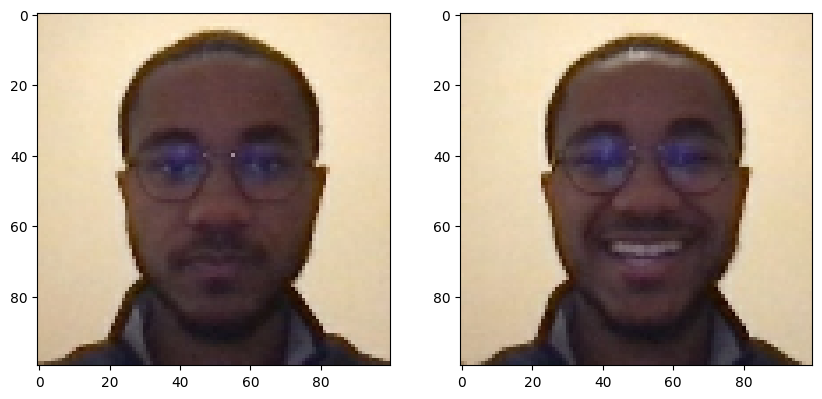

In [ ]:
# Set plot size
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

SAVES MODEL TO BE USED LATER

---



In [ ]:
siamese_model.save('siamesemodel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
L1Dist

__main__.L1Dist

GRABS MODEL FROM DIRECTORY TO BE USED

---



In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)
model = tf.keras.models.load_model('siamesemodel.h5',custom_objects={'L1Dist':L1Dist,'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
model.predict([test_input,test_val])

1/1 [==============================] - 0s 193ms/step


array([[4.2898506e-17],
       [9.9999857e-01],
       [1.6736680e-13],
       [1.0000000e+00],
       [8.1530106e-14],
       [9.0285540e-01],
       [4.8463842e-09],
       [1.0000000e+00]], dtype=float32)

In [ ]:
y_true = model.predict([test_input, test_val])
y_true

1/1 [==============================] - 0s 23ms/step


array([[4.2898506e-17],
       [9.9999857e-01],
       [1.6736680e-13],
       [1.0000000e+00],
       [8.1530106e-14],
       [9.0285540e-01],
       [4.8463842e-09],
       [1.0000000e+00]], dtype=float32)

1/1 [==============================] - 0s 22ms/step


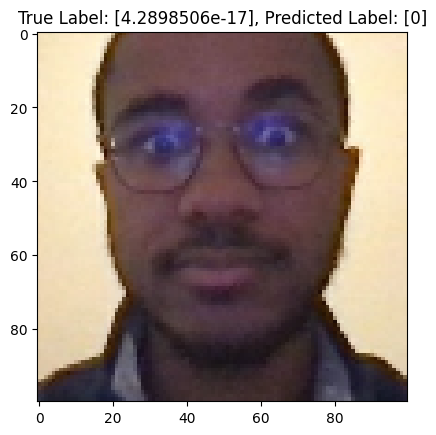

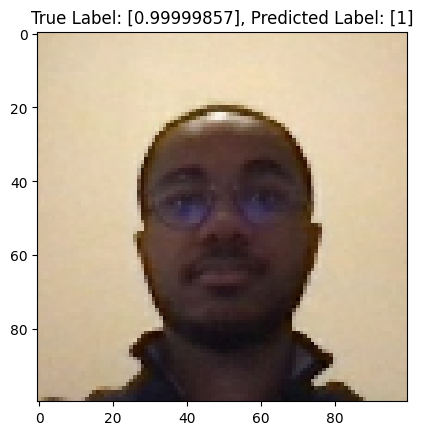

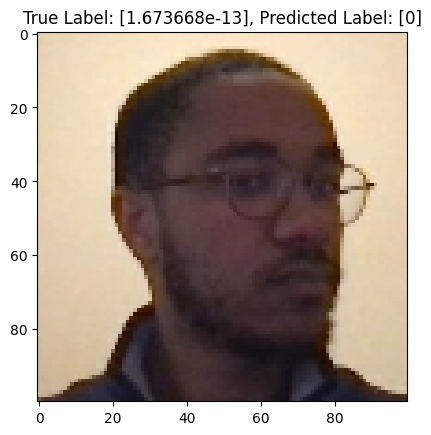

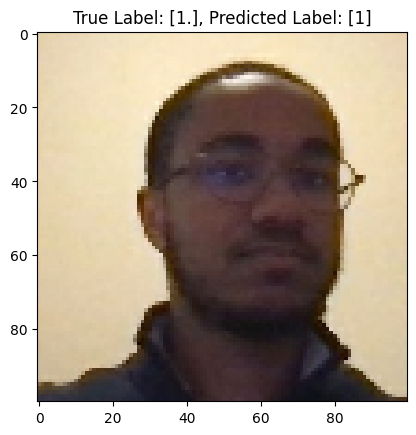

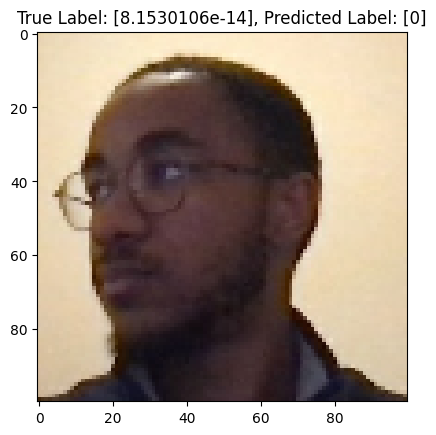

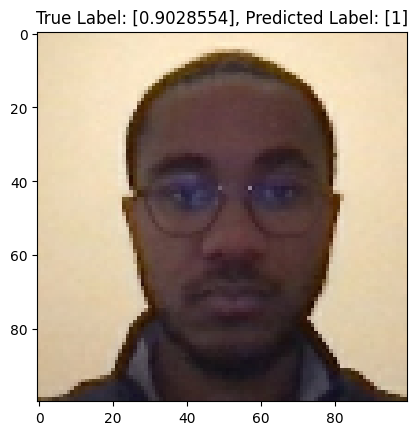

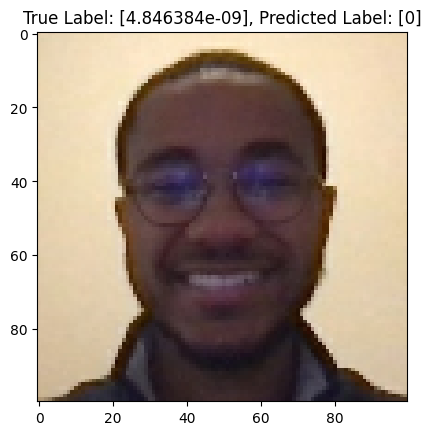

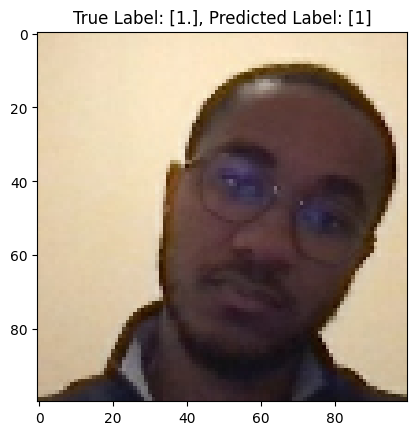

Model Accuracy: 50.00%


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score


# Assuming you have predictions and true labels
predictions = model.predict([test_input, test_val])

# Convert predictions to binary (0 or 1) based on a threshold (e.g., 0.5)
binary_predictions = (predictions > 0.3).astype(int)

# Assuming true labels are in one-hot encoding
true_labels = np.argmax(y_true, axis=1)

# Calculate accuracy
accuracy = accuracy_score(true_labels, binary_predictions)
num_images_to_display = 8  # You can adjust this based on your preference

for i in range(num_images_to_display):
    plt.figure()
    plt.imshow(test_input[i])  # Assuming 'test_input' contains the images
    plt.title(f"True Label: {y_true[i]}, Predicted Label: {binary_predictions[i]}")
    plt.show()
# Print the accuracy
print(f"Model Accuracy: {accuracy * 100:.2f}%")

In [ ]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

ZIPS DATA FOLDER AND APPLICATION FOLDER TO BE DOWNLOADED LOCALLY

---



In [ ]:
import shutil

# Source folder path (change 'source_folder' to your actual folder name)
source_folder = '/content/data'

# Zip file path (change 'zip_file.zip' to your desired zip file name)
zip_file_path = '/content/data.zip'

# Create a zip file of the folder
shutil.make_archive(zip_file_path[:-4], 'zip', source_folder)

'/content/data.zip'

In [ ]:
import shutil

# Source folder path (change 'source_folder' to your actual folder name)
source_folder = '/content/application_data'

# Zip file path (change 'zip_file.zip' to your desired zip file name)
zip_file_path = '/content/application_data.zip'

# Create a zip file of the folder
shutil.make_archive(zip_file_path[:-4], 'zip', source_folder)

'/content/application_data.zip'

VALIDIDATION THAT PATH EXIST

---



In [ ]:

os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data/input_image/input_image.jpg'

In [ ]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data/verification_images/2afc90c4-8f0e-11ee-9b75-0242ac1c000c.jpg
application_data/verification_images/2ed7f17a-8f0e-11ee-9b75-0242ac1c000c.jpg
application_data/verification_images/2f9e07e8-8f0e-11ee-9b75-0242ac1c000c.jpg
application_data/verification_images/2f1fb37a-8f0e-11ee-9b75-0242ac1c000c.jpg
application_data/verification_images/2a2da91c-8f0e-11ee-9b75-0242ac1c000c.jpg
application_data/verification_images/2aac0d7a-8f0e-11ee-9b75-0242ac1c000c.jpg
application_data/verification_images/2a6ae1a6-8f0e-11ee-9b75-0242ac1c000c.jpg
application_data/verification_images/2eea1d1e-8f0e-11ee-9b75-0242ac1c000c.jpg
application_data/verification_images/2aae3eba-8f0e-11ee-9b75-0242ac1c000c.jpg
application_data/verification_images/2f40f3d2-8f0e-11ee-9b75-0242ac1c000c.jpg
application_data/verification_images/2b7b07ce-8f0e-11ee-9b75-0242ac1c000c.jpg
application_data/verification_images/2a6d134a-8f0e-11ee-9b75-0242ac1c000c.jpg
application_data/verification_images/2f3d284c-8f0e-11ee-9b75-024

USES MODEL THAT IS IN DIRECTORY TO OUTPUT IF FACE IS IN VERIFICATION FILES ARE NOT

In [ ]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

        # Make Predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    # Detection Threshold: Metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)

    # Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold

    return results, verified


LIVE PHOTO CAPTURE TEST - press v to capture or q to quit

---



<IPython.core.display.Javascript object>

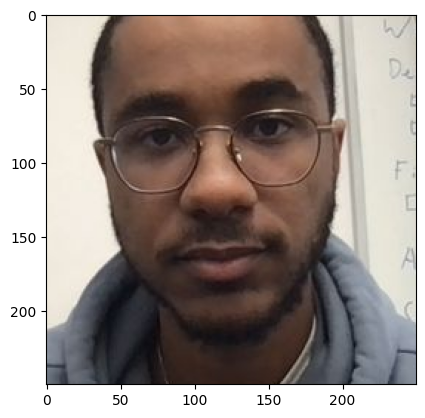

1/1 [==============================] - 0s 21ms/step
+---------------+----------------------+
|   Prediction  |        Result        |
+---------------+----------------------+
|  Prediction 1 |        [[1.]]        |
|  Prediction 2 |        [[1.]]        |
|  Prediction 3 |    [[0.9999999]]     |
|  Prediction 4 |        [[1.]]        |
|  Prediction 5 |        [[1.]]        |
|  Prediction 6 |        [[1.]]        |
|  Prediction 7 |        [[1.]]        |
|  Prediction 8 |        [[1.]]        |
|  Prediction 9 |        [[1.]]        |
| Prediction 10 |        [[1.]]        |
| Prediction 11 |        [[1.]]        |
| Prediction 12 |        [[1.]]        |
| Prediction 13 |        [[1.]]        |
| Prediction 14 |        [[1.]]        |
| Prediction 15 |        [[1.]]        |
| Prediction 16 |        [[1.]]        |
| Prediction 17 |        [[1.]]        |
| Prediction 18 |        [[1.]]        |
| Prediction 19 |        [[1.]]        |
| Prediction 20 |        [[1.]]        |
| Pre

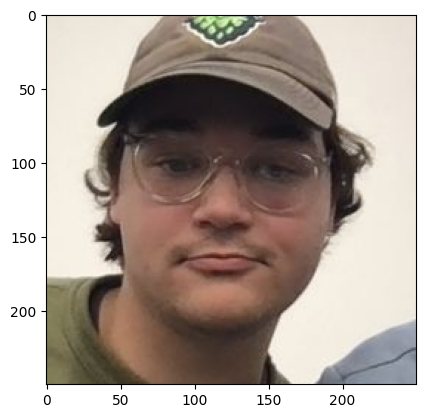

1/1 [==============================] - 0s 20ms/step
+---------------+----------------------+
|   Prediction  |        Result        |
+---------------+----------------------+
|  Prediction 1 |    [[0.9940819]]     |
|  Prediction 2 |    [[0.14577298]]    |
|  Prediction 3 |    [[0.09893857]]    |
|  Prediction 4 |    [[0.5358229]]     |
|  Prediction 5 |    [[0.99692094]]    |
|  Prediction 6 |    [[0.9825782]]     |
|  Prediction 7 |    [[0.99735177]]    |
|  Prediction 8 |    [[0.5929664]]     |
|  Prediction 9 |    [[0.98038816]]    |
| Prediction 10 |    [[0.5623842]]     |
| Prediction 11 |    [[0.9960074]]     |
| Prediction 12 |    [[0.9987379]]     |
| Prediction 13 |    [[0.34014416]]    |
| Prediction 14 |    [[0.9992895]]     |
| Prediction 15 |     [[0.672178]]     |
| Prediction 16 |    [[0.99124676]]    |
| Prediction 17 |    [[0.49430516]]    |
| Prediction 18 |    [[0.45200408]]    |
| Prediction 19 |    [[0.18045795]]    |
| Prediction 20 |    [[0.98659813]]    |
| Pre

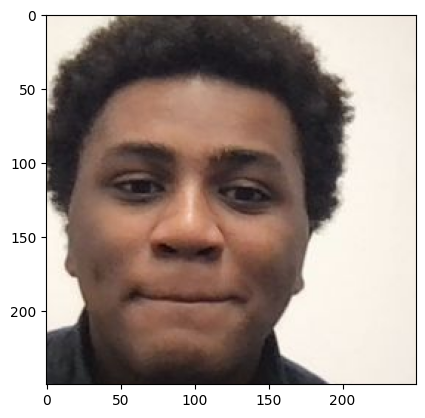

1/1 [==============================] - 0s 20ms/step
+---------------+-----------------------+
|   Prediction  |         Result        |
+---------------+-----------------------+
|  Prediction 1 |     [[0.18260485]]    |
|  Prediction 2 |     [[0.00055898]]    |
|  Prediction 3 |     [[0.0002158]]     |
|  Prediction 4 |     [[0.0022853]]     |
|  Prediction 5 |     [[0.30100384]]    |
|  Prediction 6 |     [[0.07020783]]    |
|  Prediction 7 |     [[0.33363158]]    |
|  Prediction 8 |     [[0.00249764]]    |
|  Prediction 9 |     [[0.06371003]]    |
| Prediction 10 |     [[0.00198472]]    |
| Prediction 11 |     [[0.24911527]]    |
| Prediction 12 |     [[0.5128741]]     |
| Prediction 13 |     [[0.0009978]]     |
| Prediction 14 |     [[0.6521234]]     |
| Prediction 15 |     [[0.00303352]]    |
| Prediction 16 |     [[0.13122338]]    |
| Prediction 17 |     [[0.00180778]]    |
| Prediction 18 |     [[0.00169858]]    |
| Prediction 19 |     [[0.00050765]]    |
| Prediction 20 |     [[

In [ ]:

capture_frames = True

# Path to save the captured images


# JavaScript code to access the webcam and listen for the 'q' and 'a' keys
js_code = """
async function initCamera() {
    const video = document.createElement('video');
    document.body.appendChild(video);

    // Get user media
    const stream = await navigator.mediaDevices.getUserMedia({ 'video': true });

    // Set the video source
    video.srcObject = stream;

    // Wait for the video to be loaded
    await video.play();

    // Create canvas for capturing frames
    const canvas = document.createElement('canvas');
    canvas.width = video.videoWidth;
    canvas.height = video.videoHeight;
    document.body.appendChild(canvas);

    // Listen for keyboard events
    document.addEventListener('keydown', (event) => {
        if (event.key === 'q') {
            // Capture a frame when the 'q' key is pressed
            canvas.getContext('2d').drawImage(video, 0, 0);
            const imageData = canvas.toDataURL('image/jpeg', 0.8);
            google.colab.kernel.invokeFunction('notebook.run', [imageData], {});

            // Stop the video stream
            stream.getTracks().forEach(track => track.stop());
            video.remove();
        } else if (event.key === 'v') {
            // Send a signal to the Python code to save the current frame
            canvas.getContext('2d').drawImage(video, 0, 0);
            const imageData = canvas.toDataURL('image/jpeg', 0.8);
            google.colab.kernel.invokeFunction('notebook.verification', [imageData], {});

        }
    });

    return;
}

initCamera();
"""

# Execute the JavaScript code only if capture_frames is True
if capture_frames:
    display(Javascript(js_code))

# Function to convert base64 image to OpenCV format
def base64_to_image(base64_img):
    decoded = base64.b64decode(base64_img.split(',')[1])
    nparr = np.frombuffer(decoded, np.uint8)
    return cv2.imdecode(nparr, cv2.IMREAD_COLOR)

# Function to run when a frame is captured
def on_frame_captured(image_data):
    global capture_frames
    # Convert base64 image to OpenCV format
    frame = base64_to_image(image_data)

    # Crop the frame to the specified region of interest
    roi = frame[120:120+250, 200:200+250, :]

    # Display the cropped frame using plt.imshow
    plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    plt.axis('on')  # Turn off axis labels
    plt.show()

    # Print the shape of the cropped frame
    print("Cropped Frame Shape:", roi.shape)

    # Stop capturing frames
    capture_frames = False

def verification(image_data):
  global capture_frames
  # Convert base64 image to OpenCV format

  frame = base64_to_image(image_data)
  roi = frame[120:120+250, 200:200+250, :]
  # Generate a unique filename using UUID

  # Save the image to the specified path
  cv2.imwrite(os.path.join('application_data','input_image','input_image.jpg'),roi)

  plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
  plt.show()
  results, verified = verify(model, 0.85, 0.5)
  ground_truth = 1  # Set the actual label (1 or 0) based on your dataset

  # Calculate accuracy
  accuracy = sum(results) / len(results)

  table = PrettyTable()
  table.field_names = ["Prediction", "Result"]


  for i, result in enumerate(results):
      table.add_row([f"Prediction {i + 1}", result])

  table.add_row(["Accuracy", f"{float(accuracy) * 100:.2f}%"])
  table.add_row(["Verified", f"{verified} - input_img.jpg"])

  print(table)
  print("\n")



output.register_callback('notebook.run', on_frame_captured)
output.register_callback('notebook.verification', verification)


In [ ]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data/input_image/input_image.jpg'

In [ ]:
main_directory = 'application_data'
faces_directory = 'faces'
# Create the full path
full_path = os.path.join(main_directory, faces_directory)
full_path

'application_data/faces'

GOES THROUGH EACH PHOTO IN FACES FOLDER CAN BE ANYTHING AND WILL COMPARE IF ITS IN VERIFICATION OR NOT - will compare with every photo in verification images so the more the longer it will take

---



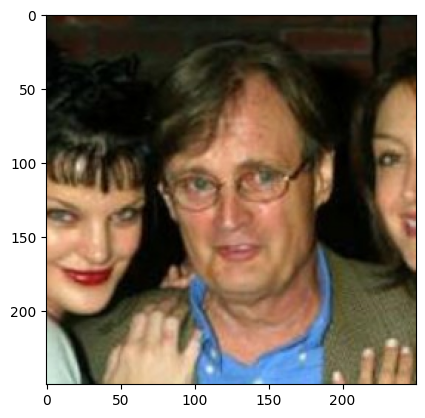

1/1 [==============================] - 0s 23ms/step
+---------------+---------------------------------+
|   Prediction  |              Result             |
+---------------+---------------------------------+
|  Prediction 1 |        [[6.3070695e-11]]        |
|  Prediction 2 |         [[1.197653e-13]]        |
|  Prediction 3 |        [[6.1578665e-14]]        |
|  Prediction 4 |         [[6.332472e-13]]        |
|  Prediction 5 |        [[1.1910871e-10]]        |
|  Prediction 6 |        [[2.1849886e-11]]        |
|  Prediction 7 |        [[1.3902263e-10]]        |
|  Prediction 8 |         [[7.366127e-13]]        |
|  Prediction 9 |        [[1.9879338e-11]]        |
| Prediction 10 |         [[6.104859e-13]]        |
| Prediction 11 |         [[9.248777e-11]]        |
| Prediction 12 |        [[2.9016556e-10]]        |
| Prediction 13 |        [[2.8434015e-13]]        |
| Prediction 14 |         [[5.116808e-10]]        |
| Prediction 15 |         [[9.367538e-13]]        |
| Prediction

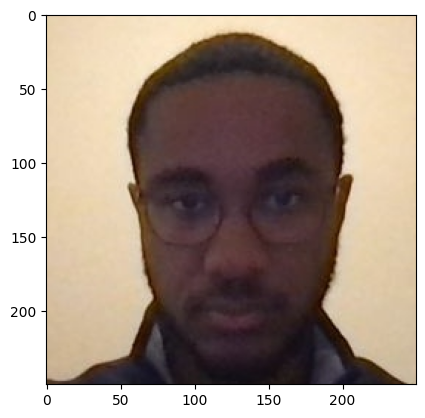

1/1 [==============================] - 0s 20ms/step
+---------------+-------------------------------------------------+
|   Prediction  |                      Result                     |
+---------------+-------------------------------------------------+
|  Prediction 1 |                      [[1.]]                     |
|  Prediction 2 |                   [[0.999998]]                  |
|  Prediction 3 |                  [[0.99999857]]                 |
|  Prediction 4 |                  [[0.99999976]]                 |
|  Prediction 5 |                      [[1.]]                     |
|  Prediction 6 |                      [[1.]]                     |
|  Prediction 7 |                      [[1.]]                     |
|  Prediction 8 |                  [[0.9999999]]                  |
|  Prediction 9 |                      [[1.]]                     |
| Prediction 10 |                  [[0.9999999]]                  |
| Prediction 11 |                      [[1.]]                   

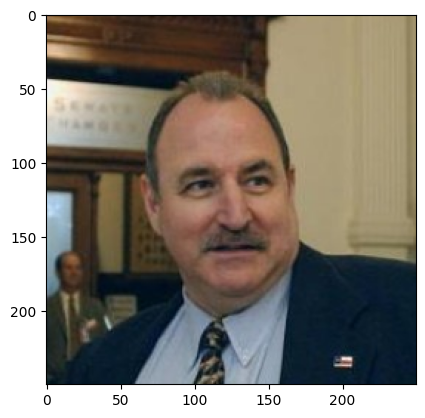

1/1 [==============================] - 0s 23ms/step
+---------------+---------------------------------+
|   Prediction  |              Result             |
+---------------+---------------------------------+
|  Prediction 1 |         [[5.308462e-11]]        |
|  Prediction 2 |        [[4.7875264e-14]]        |
|  Prediction 3 |        [[5.2599045e-14]]        |
|  Prediction 4 |         [[3.155004e-13]]        |
|  Prediction 5 |        [[1.0722057e-10]]        |
|  Prediction 6 |        [[1.7408821e-11]]        |
|  Prediction 7 |         [[1.220131e-10]]        |
|  Prediction 8 |        [[4.2797013e-13]]        |
|  Prediction 9 |        [[1.4801103e-11]]        |
| Prediction 10 |        [[4.2211934e-13]]        |
| Prediction 11 |        [[8.0938194e-11]]        |
| Prediction 12 |        [[2.5759078e-10]]        |
| Prediction 13 |        [[1.6207086e-13]]        |
| Prediction 14 |         [[4.684087e-10]]        |
| Prediction 15 |         [[6.656607e-13]]        |
| Prediction

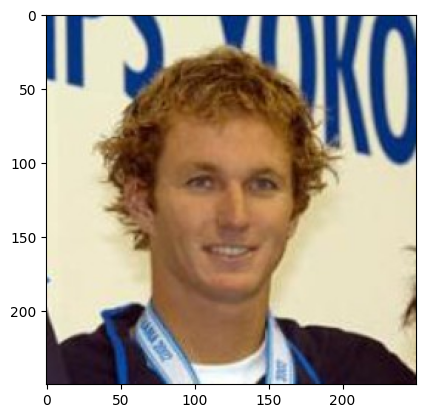

1/1 [==============================] - 0s 27ms/step
+---------------+--------------------------------+
|   Prediction  |             Result             |
+---------------+--------------------------------+
|  Prediction 1 |       [[4.7951646e-11]]        |
|  Prediction 2 |       [[1.2510662e-13]]        |
|  Prediction 3 |        [[5.78296e-14]]         |
|  Prediction 4 |        [[5.956403e-13]]        |
|  Prediction 5 |        [[8.860089e-11]]        |
|  Prediction 6 |       [[1.7212405e-11]]        |
|  Prediction 7 |       [[1.0371937e-10]]        |
|  Prediction 8 |        [[6.726728e-13]]        |
|  Prediction 9 |       [[1.6014742e-11]]        |
| Prediction 10 |        [[5.419789e-13]]        |
| Prediction 11 |        [[6.936823e-11]]        |
| Prediction 12 |       [[2.1441099e-10]]        |
| Prediction 13 |        [[2.679773e-13]]        |
| Prediction 14 |       [[3.7514422e-10]]        |
| Prediction 15 |       [[8.1756883e-13]]        |
| Prediction 16 |       [[3.31

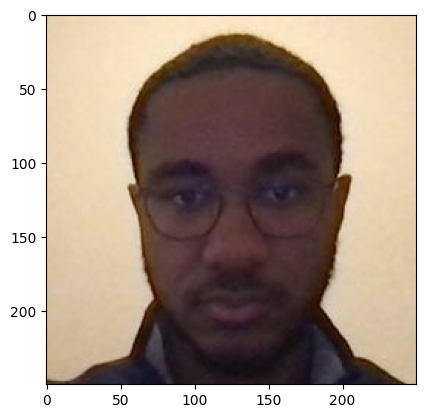

1/1 [==============================] - 0s 28ms/step
+---------------+-------------------------------------------------+
|   Prediction  |                      Result                     |
+---------------+-------------------------------------------------+
|  Prediction 1 |                      [[1.]]                     |
|  Prediction 2 |                  [[0.9999676]]                  |
|  Prediction 3 |                  [[0.9999728]]                  |
|  Prediction 4 |                  [[0.9999958]]                  |
|  Prediction 5 |                      [[1.]]                     |
|  Prediction 6 |                      [[1.]]                     |
|  Prediction 7 |                      [[1.]]                     |
|  Prediction 8 |                   [[0.999997]]                  |
|  Prediction 9 |                  [[0.9999999]]                  |
| Prediction 10 |                  [[0.99999726]]                 |
| Prediction 11 |                      [[1.]]                   

KeyboardInterrupt: ignored

In [ ]:

from prettytable import PrettyTable

#Test random photos to check for Alvin or if not
for image_file in os.listdir(full_path):
    if image_file.endswith(('.jpg', '.jpeg', '.png')):  # Add more extensions if needed
        image_path = os.path.join(full_path, image_file)

        # Read the image
        frame = cv2.imread(image_path)

        # Apply the same ROI extraction as in your original code

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)

        # Display the ROI using Matplotlib
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.show()

        # Perform verification
        results, verified = verify(model, 0.85, 0.5)

        ground_truth = 1  # Set the actual label (1 or 0) based on your dataset

        # Calculate accuracy
        accuracy = sum(results) / len(results)

        table = PrettyTable()
        table.field_names = ["Prediction", "Result"]


        for i, result in enumerate(results):
            table.add_row([f"Prediction {i + 1}", result])

        table.add_row(["Accuracy", f"{float(accuracy) * 100:.2f}%"])
        table.add_row(["Verified", f"{verified} - {image_file}"])

        print(table)


        print("\n")